### Exploring the data

In [3]:
! pip install nibabel imageio Pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.7 MB/s eta 0:00:00a 0:00:01


In [3]:
! pip install h5py


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import nibabel as nib
import tensorflow as tf
import nibabel as nib

from scipy.ndimage import zoom
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout

In [ ]:
## irregular spacing images

In [7]:
image_path = 'MusCNN/Musimages/Fgf10OE_3_C.mnc'
image = nib.load(image_path)
image_data = image.get_fdata()

/opt/anaconda3/lib/python3.11/site-packages/nibabel/minc2.py:68: UserWarning: Invalid spacing declaration: b'xspace'; assuming regular
  warnings.warn(f'Invalid spacing declaration: {spacing}; assuming regular')


### Test on slicing the data on the third dimention

In [10]:
image_path = 'Fgf10OE_1_C.mnc'
image = nib.load(image_path)
image_data = image.get_fdata()

In [12]:
image_data.shape

(979, 586, 642)

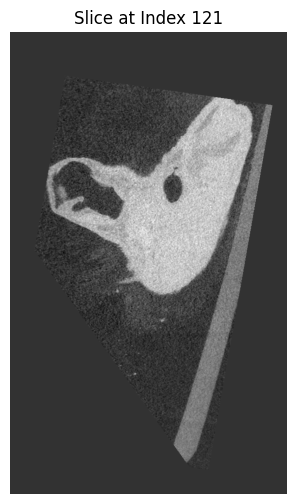

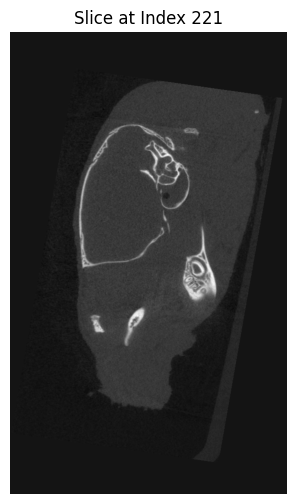

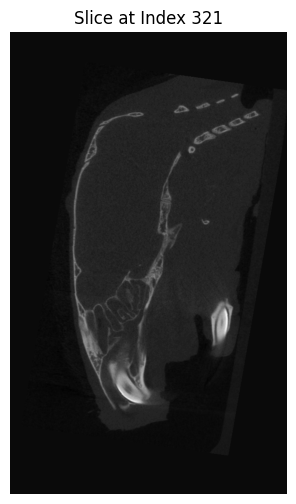

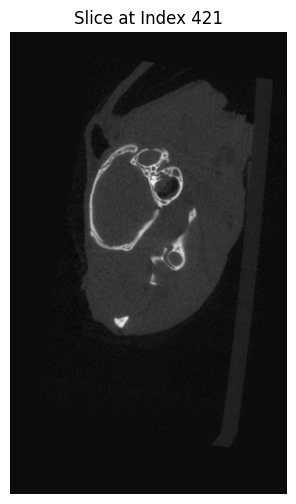

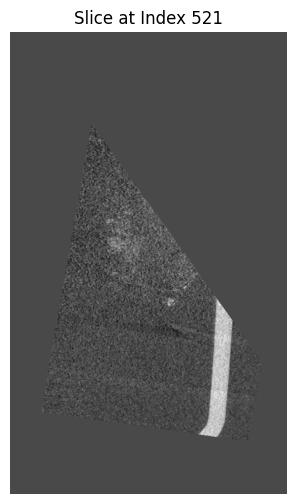

In [60]:
slice_indices = [121, 221, 321, 421, 521]

for slice_index in slice_indices:
    plt.figure(figsize=(6, 6))
    plt.imshow(image_data[:, :, slice_index], cmap='gray') 
    plt.title(f'Slice at Index {slice_index}') 
    plt.axis('off') 
    plt.show()  

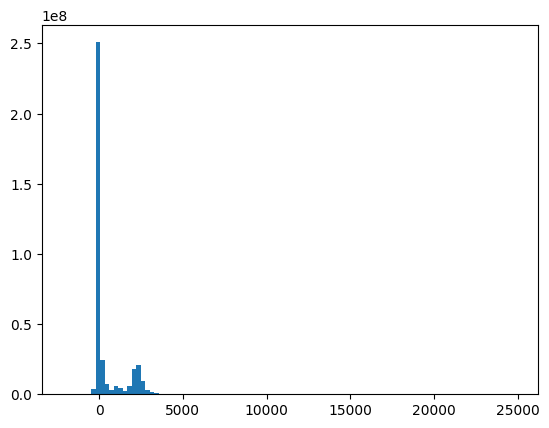

In [61]:
plt.hist(np.ravel(image_data), bins=100);

### Test on slicing the data on the second dimention

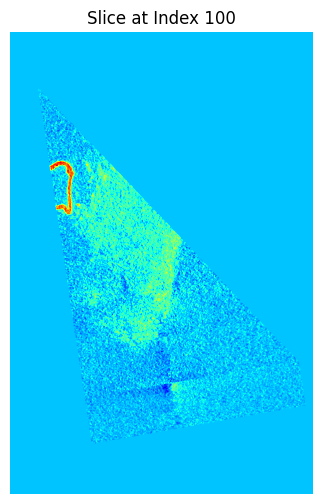

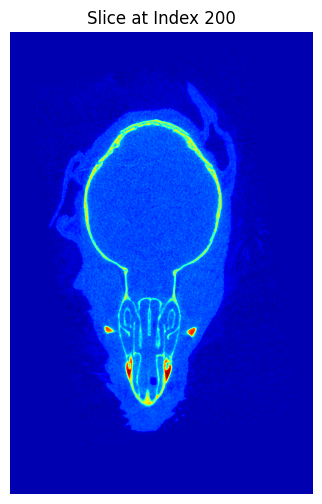

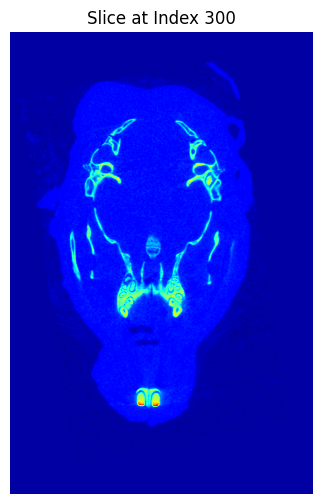

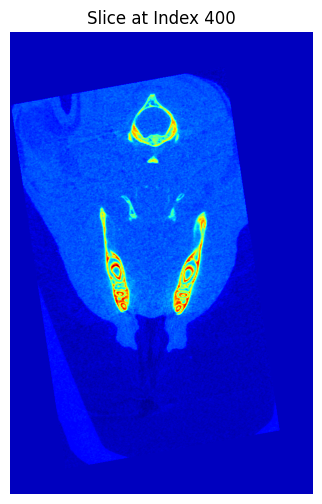

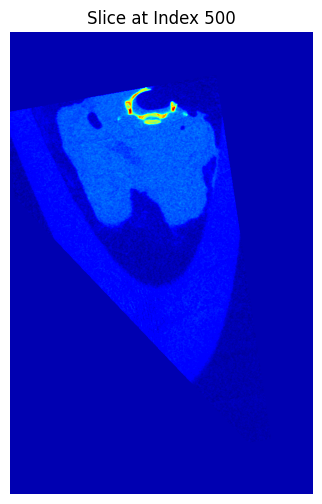

In [47]:
slice_indices = [100,200,300,400,500]

for slice_index in slice_indices:
    plt.figure(figsize=(6, 6))  
    plt.imshow(image_data[:, slice_index, :], cmap='jet')  
    plt.title(f'Slice at Index {slice_index}')  
    plt.axis('off')  
    plt.show()  

### Experiment for visualizing the image

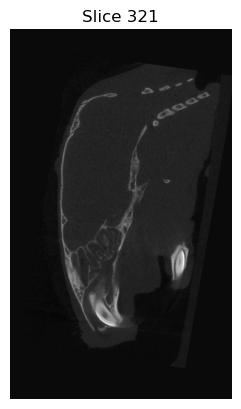

In [13]:
slice_index = image_data.shape[2] // 2  # Middle index of the third dimension

slice_data = image_data[:, :, slice_index]

# Normalize the slice for better visualization
normalized_slice = (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data))

plt.imshow(normalized_slice, cmap='gray')
plt.axis('off') 
plt.title(f'Slice {slice_index}')
plt.show()


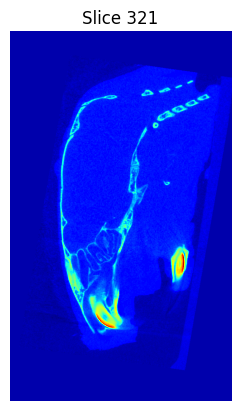

In [18]:
plt.imshow(normalized_slice, cmap='jet')
plt.axis('off') 
plt.title(f'Slice {slice_index}')
plt.show()

### Computing a voxel volume

In [63]:
nii = nib.load('Fgf10OE_1_C.mnc')
sx, sy, sz = nii.header.get_zooms()
volume = sx * sy * sz

In [64]:
print(volume)

4.287500000000001e-05


In [65]:
sx, sy, sz

(0.035, 0.035, 0.035)

### Preparing Images and Labels (Will change later)

In [11]:
def load_images_and_labels(csv_path, images_folder_path):
    # Load the CSV file into a dataframe
    data = pd.read_csv(csv_path)

    # Initialize a list to store image data and labels
    image_data_list = []
    labels = []

    # Iterate over the rows in the dataframe
    for index, row in data.iterrows():
        # Construct the image file name and path
        image_name = row['Biosample'] + '.mnc'
        image_path = os.path.join(images_folder_path, image_name)

        # Attempt to read the image file
        try:
            image = nib.load(image_path)
            image_data = image.get_fdata()
            image_data_list.append(image_data)
        except FileNotFoundError:
            print(f"Image file not found: {image_path}")
            continue
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            continue

        # Create the label based on the 'Experimental_Group' column
        label = 0 if row['Experimental_Group'] == 'Control' else 1
        labels.append(label)

    # Create a new dataframe with image names and labels
    df = pd.DataFrame({
        'image_name': data['Biosample'] + '.mnc',
        'label': labels
    })

    return df


# Usage
images_folder_path = 'MusCNN/Musimages'
csv_path = 'MusMorph_Metadata_Exact_Match.csv'
df = load_images_and_labels(csv_path, images_folder_path)

# Now `df` contains the image names and labels
# Save `df` to a new CSV if needed
df.to_csv('image_names_and_labels.csv', index=False)


/opt/anaconda3/lib/python3.11/site-packages/nibabel/minc2.py:68: UserWarning: Invalid spacing declaration: b'xspace'; assuming regular
  warnings.warn(f'Invalid spacing declaration: {spacing}; assuming regular')


In [16]:
def create_image_labels_csv(csv_path, images_folder_path):
    # Load the CSV file into a dataframe
    data = pd.read_csv(csv_path)

    # Add the .mnc extension to the 'Biosample' column to form the image file names
    data['image_name'] = data['Biosample'] + '.mnc'

    # Check if the image files exist
    data['image_exists'] = data['image_name'].apply(lambda x: os.path.exists(os.path.join(images_folder_path, x)))

    # Create a label column where 'control' is labeled as 0, others as 1
    data['label'] = data['Experimental_Group'].apply(lambda x: 0 if x == 'Control' else 1)

    # Filter out entries where the image does not exist
    data = data[data['image_exists'] == True]
    data.drop(columns=['image_exists'], inplace=True)  # Cleanup the dataframe

    # Save the filtered data to a new CSV file
    output_csv_path = 'image_names_and_labels.csv'
    data[['image_name', 'label']].to_csv(output_csv_path, index=False)
    
    return output_csv_path

# Usage

images_folder_path = 'MusCNN/Musimages'
csv_path = 'MusMorph_Metadata_Exact_Match.csv'
output_csv_path = create_image_labels_csv(csv_path, images_folder_path)
print(f"CSV file with image names and labels created at: {output_csv_path}")


CSV file with image names and labels created at: image_names_and_labels.csv


In [2]:
path_to_file = 'image_names_and_labels.csv'
data = pd.read_csv(path_to_file)
print(data.head())

         image_name  label
0   Fgf10OE_1_C.mnc      0
1  Fgf10OE_1_OE.mnc      1
2   Fgf10OE_2_C.mnc      0
3  Fgf10OE_2_OE.mnc      1
4   Fgf10OE_3_C.mnc      0


In [3]:
##just for testing images' shape

def get_image_shapes(csv_path, images_folder_path):
    
    data = pd.read_csv(csv_path)
    data['full_image_path'] = data['image_name'].apply(lambda x: os.path.join(images_folder_path, x))

    image_shapes = {}

    # Iterate through each image path and load the image to get its shape
    for index, row in data.iterrows():
        image_path = row['full_image_path']
        try:
            image = nib.load(image_path)
            image_shapes[row['image_name']] = image.shape
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            image_shapes[row['image_name']] = None

    return image_shapes

#test
csv_path = path_to_file
images_folder_path = 'MusCNN/Musimages'
image_shapes = get_image_shapes(csv_path, images_folder_path)
print(image_shapes)


{'Fgf10OE_1_C.mnc': (979, 586, 642), 'Fgf10OE_1_OE.mnc': (979, 586, 642), 'Fgf10OE_2_C.mnc': (979, 586, 642), 'Fgf10OE_2_OE.mnc': (979, 586, 642), 'Fgf10OE_3_C.mnc': (979, 586, 642), 'Fgf10OE_3_OE.mnc': (979, 586, 642), 'Fgf10OE_4_C.mnc': (979, 586, 642), 'Fgf10OE_4_OE.mnc': (979, 586, 642), 'Fgf10OE_5_C.mnc': (979, 586, 642), 'Fgf10OE_5_OE.mnc': (979, 586, 642), 'Fgf10OE_6_C.mnc': (979, 586, 642), 'Fgf10OE_6_OE.mnc': (979, 586, 642), 'Fgf10OE_7_C.mnc': (979, 586, 642), 'Fgf10OE_7_OE.mnc': (979, 586, 642), 'Fgf10OE_8_OE.mnc': (979, 586, 642), 'FGF3_F1.mnc': (979, 586, 642), 'FGF3_F10.mnc': (979, 586, 642), 'FGF3_F11.mnc': (979, 586, 642), 'FGF3_F12.mnc': (979, 586, 642), 'FGF3_F13.mnc': (979, 586, 642), 'FGF3_F14.mnc': (979, 586, 642), 'FGF3_F15.mnc': (979, 586, 642), 'FGF3_F17.mnc': (979, 586, 642), 'FGF3_F18.mnc': (979, 586, 642)}


/opt/anaconda3/lib/python3.11/site-packages/nibabel/minc2.py:68: UserWarning: Invalid spacing declaration: b'xspace'; assuming regular
  warnings.warn(f'Invalid spacing declaration: {spacing}; assuming regular')


#### All images have shape of (979, 586, 642)

### 3D CNN

In [4]:
def preprocess_image(file_path, new_shape=(256, 256, 256)):
    # Load the .mnc file
    image = nib.load(file_path.numpy().decode())
    image_data = image.get_fdata()
    
    # Resize image to new_shape (Downsampling)
    resized_image = zoom(image_data, (new_shape[0]/image_data.shape[0], 
                                      new_shape[1]/image_data.shape[1], 
                                      new_shape[2]/image_data.shape[2]), order=1)
    
    # Normalize to range [0, 1]
    normalized_image = (resized_image - np.min(resized_image)) / (np.max(resized_image) - np.min(resized_image))
    
    #To make sure the image has a single channel dimension
    normalized_image = normalized_image[..., np.newaxis] 
    return normalized_image

def load_and_preprocess_image(file_path, label):
    image = tf.py_function(preprocess_image, [file_path], Tout=tf.float32)
    image.set_shape((256, 256, 256, 1))  # Explicitly set the shape after preprocessing
    return image, label


In [5]:
# Example usage with tf.data.Dataset
base_dir = 'MusCNN/Musimages'
image_paths = [os.path.join(base_dir, fname) for fname in data['image_name'].tolist()]

labels = data['label'].tolist()

dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(load_and_preprocess_image)
train_dataset = dataset.batch(6)  # Use an appropriate batch size later
validation_dataset = dataset.skip(int(0.8 * 24)).batch(6)

In [6]:
def build_3d_cnn_model():
    model = Sequential([
        # Input layer: Accepts images of shape (256, 256, 256, 1)
        Conv3D(16, kernel_size=(3, 3, 3), activation='relu', input_shape=(256, 256, 256, 1)),
        MaxPooling3D(pool_size=(2, 2, 2)),  # to (128, 128, 128, 16)

        # Second layer set
        Conv3D(32, kernel_size=(3, 3, 3), activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2)),  # to (64, 64, 64, 32)

        # Third layer set
        Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2)),  # to (32, 32, 32, 64)

        # Fourth layer set
        Conv3D(128, kernel_size=(3, 3, 3), activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2)),  # to (16, 16, 16, 128)

        # Fifth layer set
        Conv3D(256, kernel_size=(3, 3, 3), activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2)),  # Reduces to (8, 8, 8, 256)

        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = build_3d_cnn_model()


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [7]:
for images, labels in train_dataset.take(1):
    print("Images shape:", images.shape) 
    print("Labels shape:", labels.shape)
    print("Images dtype:", images.dtype)
    print("Labels dtype:", labels.dtype)


Images shape: (6, 256, 256, 256, 1)
Labels shape: (6,)
Images dtype: <dtype: 'float32'>
Labels dtype: <dtype: 'int32'>


2024-04-12 19:51:45.869783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
history = model.fit(train_dataset, epochs=20, validation_data=validation_dataset, verbose=1)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 415s 107s/step - accuracy: 0.4667 - loss: 0.7007 - val_accuracy: 0.6000 - val_loss: 0.7722
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 414s 105s/step - accuracy: 0.5444 - loss: 0.7431 - val_accuracy: 0.6000 - val_loss: 0.6807
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 411s 105s/step - accuracy: 0.5444 - loss: 0.6797 - val_accuracy: 0.6000 - val_loss: 0.6860
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 414s 106s/step - accuracy: 0.5444 - loss: 0.7073 - val_accuracy: 0.6000 - val_loss: 0.6708
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 419s 108s/step - accuracy: 0.4889 - loss: 0.7021 - val_accuracy: 0.6000 - val_loss: 0.6730
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 420s 107s/step - accuracy: 0.5278 - loss: 0.6617 - val_accuracy: 0.6000 - val_loss: 0.6592
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 421s 107s/step - accuracy: 0.6000 - loss: 0.6285 - val_accuracy: 0.6000 - val_loss: 0.6076
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 423s 108s/step - accuracy: 0.9111 - loss: 0.3858 - val_accuracy: 0.6000 - v

In [10]:
model.save('CNN_MusMorph_Model.h5')

In [11]:
model.save('CNN_MusMorph_Model.keras')


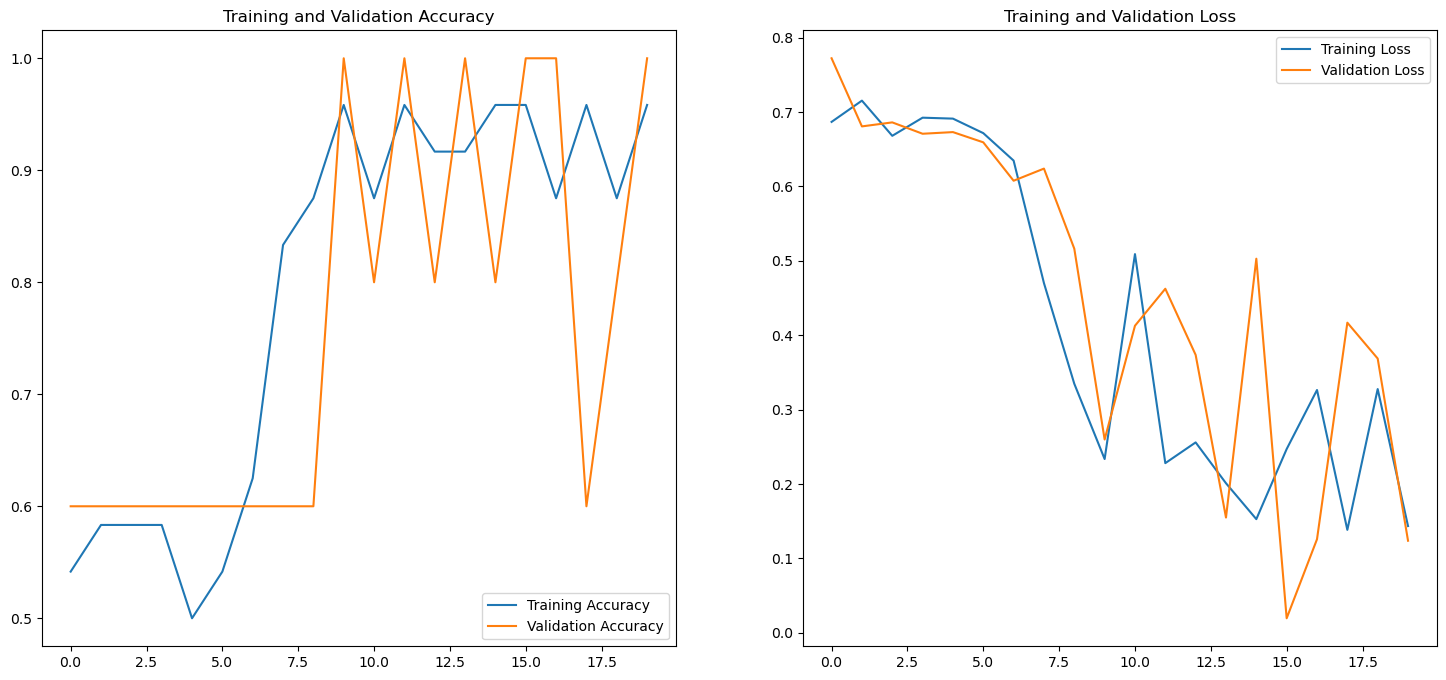

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 20
epochs_range = range(epochs)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()